# Task 1: Predict the global rating score

We will use the data and treatments provided by the teacher.

300 frames were extracted from each video (reduction to 1fps) and from these 300 frames 300 features were extracted.

The proposed architecture would be a combination of a CNN with 3 LSTMs in cascade, one focused on capturing short dependencies and the others paying attention to the video as a whole.

As we already have previously collected features, a 1D_CNN will be used to emulate the CNN and refine the features.

### 1. Inicialization

In [5]:
# Imports
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import torch
import torch.nn as nn
import torchvision.transforms as transforms

from torch import Tensor
from torch.nn import Sequential, Linear, ReLU, LSTM, Module, Conv1d
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.utils.data import Subset
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit
from livelossplot import PlotLosses

from collections import Counter

In [6]:
# GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
         for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

device = get_default_device()   
print(device)

cuda


In [7]:
# Contants 
PATH_TRAIN_OSATS = "../../OSS_dataset/Train/OSATS.csv"
PATH_TRAIN_REDUCED = "../../OSS_dataset/Train/numpy_files_reduced/"
PATH_TRAIN_VIDEOS = "../../OSS_dataset/Train/videos/"

PATH_TEST_OSATS = "../../OSS_dataset/Test/OSATS.csv"
PATH_TEST_REDUCED = "../../OSS_dataset/Test/numpy_files_reduced/"

BATCH_SIZE = 16

OUTPUT_FOLDER = "./results/"

In [8]:
SEED = 42

torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

### 2. Data Preparation 

In [9]:
df = pd.read_csv(PATH_TRAIN_OSATS, sep=';')
df.head()

,STUDENT,GROUP,TIME,SUTURES,INVESTIGATOR,VIDEO,OSATS_RESPECT,OSATS_MOTION,OSATS_INSTRUMENT,OSATS_SUTURE,OSATS_FLOW,OSATS_KNOWLEDGE,OSATS_PERFORMANCE,OSATS_FINAL_QUALITY,GLOBA_RATING_SCORE
0,AHO729,E-LEARNING,PRE,1,A,P54M,2,1,2,2,1,2,2,1,13
1,AHO729,E-LEARNING,PRE,1,B,P54M,2,1,3,1,2,1,2,1,13
2,AHO729,E-LEARNING,PRE,1,C,P54M,2,1,1,1,1,1,1,1,9
3,AHO729,E-LEARNING,POST,"4,5",A,M45P,4,4,4,3,3,4,3,3,28
4,AHO729,E-LEARNING,POST,"4,5",B,M45P,2,3,4,3,3,4,3,3,25


In [10]:
class GRSDataset(Dataset):
    def __init__(self, path_data, path_label, num_frames=300, transforms=None):
        self.num_frames = num_frames
        self.transforms = transforms

        osats = pd.read_csv(path_label, sep = ';')
        self.labels = (
            osats.groupby("VIDEO")["GLOBA_RATING_SCORE"]
            .mean()
            .round()
            .apply(self.grs_to_class)
            .to_dict()
        )

        self.videos = {
            f.replace(".npz", ""): os.path.join(path_data, f)
            for f in os.listdir(path_data)
            if f.endswith(".npz") and f.replace(".npz", "") in self.labels
        }

    def __len__(self):
        return len(self.videos)

    def __getitem__(self, idx):
        video_name = list(self.videos.keys())[idx]
        path = self.videos[video_name]
        
        data = np.load(path)
        video = data["video"].reshape(-1, 300)
        label = self.labels[video_name]

        
        T = video.shape[0]
        if T >= self.num_frames:
            video = video[:self.num_frames]
        
        video_tensor = torch.tensor(video, dtype=torch.float32)

        if self.transforms:
            video_tensor = self.transforms(video_tensor)

        return video_tensor, torch.tensor(label, dtype=torch.long)

    @staticmethod
    def grs_to_class(grs):
        if 8 <= grs <= 15:
            return 0  # novice
        elif 16 <= grs <= 23:
            return 1  # intermediate
        elif 24 <= grs <= 31:
            return 2  # proeficient
        elif 32 <= grs <= 40:
            return 3  # specialist
        else:
            return -1  # GRS not in range

In [ ]:
def grs_prepare_data_loaders(test = 0.2, val = 0.1, transforms=None):
    generator = torch.Generator().manual_seed(SEED)

    full_dataset = GRSDataset( path_data=PATH_TRAIN_REDUCED, path_label=PATH_TRAIN_OSATS, transforms=transforms)
    #test_dataset = GRSDataset( path_data=PATH_TEST_REDUCED, path_label=PATH_TEST_OSATS, transforms=transforms)
    
    total_len = len(full_dataset)
    val_size = int(val * total_len)
    test_size = int(test * total_len)
    train_size = total_len - val_size - test_size

    train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size], generator=generator)
    
    # DataLoaders 
    train_dl = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_dl   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_dl  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # DataLoaders without Batching
    train_dl_all = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=False)
    val_dl_all   = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)
    test_dl_all  = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

    return train_dl, val_dl, test_dl, train_dl_all, val_dl_all, test_dl_all


In [12]:
feature_transforms = transforms.Compose([
    transforms.Lambda(lambda x: (x - x.min()) / (x.max() - x.min() + 1e-6))
])

In [13]:
train_dl, val_dl, test_dl, train_dl_all, val_dl_all, test_dl_all = grs_prepare_data_loaders(transforms= feature_transforms)

#### 2.1 Visualize Data

In [14]:
def visualize_dataset(train, test, val):
    print(f"Casos de Treino: {len(train.dataset)}")
    print(f"Casos de Validação: {len(val.dataset)}")
    print(f"Casos de Teste: {len(test.dataset)}")

    x, y = next(iter(train)) 
    print(f"(TREINO) Shape tensor batch -> input: {x.shape}, output: {y.shape}")

    x, y = next(iter(val)) 
    print(f"(VAL) Shape tensor batch -> input: {x.shape}, output: {y.shape}")

    x, y = next(iter(test))
    print(f"(TESTE) Shape tensor batch -> input: {x.shape}, output: {y.shape}")

    print(f'Valor maximo:{torch.max(x)} Valor mínimo:{torch.min(x)}')


In [15]:
visualize_dataset(train_dl, test_dl, val_dl)

Casos de Treino: 221
Casos de Validação: 31
Casos de Teste: 62
(TREINO) Shape tensor batch -> input: torch.Size([16, 300, 300]), output: torch.Size([16])
(VAL) Shape tensor batch -> input: torch.Size([16, 300, 300]), output: torch.Size([16])
(TESTE) Shape tensor batch -> input: torch.Size([16, 300, 300]), output: torch.Size([16])
Valor maximo:1.0 Valor mínimo:0.0


In [133]:
def plot_class_distribution(train, test, val, class_names=None):
    def get_class_counts(loader):
        dataset = loader.dataset  # Subset
        counter = Counter()
        for _, label in dataset:
            counter[int(label)] += 1
        return counter

    train_counts = get_class_counts(train)
    test_counts  = get_class_counts(test)
    val_counts   = get_class_counts(val)

    all_classes = sorted(set(train_counts) | set(test_counts) | set(val_counts))
    if class_names is None:
        class_names = [str(c) for c in all_classes]

    train_vals = [train_counts.get(c, 0) for c in all_classes]
    test_vals  = [test_counts.get(c, 0) for c in all_classes]
    val_vals   = [val_counts.get(c, 0) for c in all_classes]

    x = range(len(all_classes))
    bar_width = 0.25

    plt.figure(figsize=(8, 5))
    plt.bar([i - bar_width for i in x], train_vals, width=bar_width, label='Treino')
    plt.bar(x, test_vals, width=bar_width, label='Teste')
    plt.bar([i + bar_width for i in x], val_vals, width=bar_width, label='Validação')

    plt.xlabel('Classe')
    plt.ylabel('Número de exemplos')
    plt.title('Distribuição de classes por conjunto')
    plt.xticks(ticks=x, labels=class_names)
    plt.legend()
    plt.tight_layout()
    plt.show()



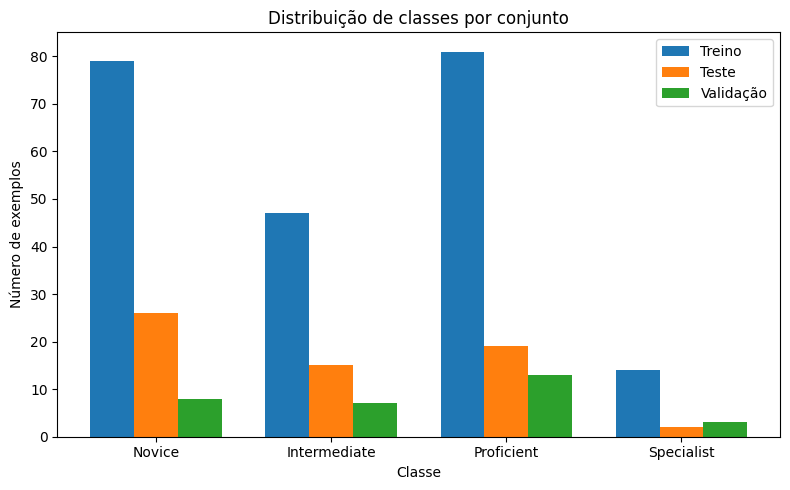

In [134]:
plot_class_distribution(train_dl, test_dl, val_dl, class_names=['Novice', 'Intermediate', 'Proficient', 'Specialist'])

### 3. Model

#### Architecture
- **1D Convolutional Encoder**:
  - Simulates the role of a CNN by applying two stacked `Conv1d` layers over the temporal dimension.
  - Input shape: `(B, T, F)` → reshaped to `(B, F, T)` for `Conv1d`.
  - Extracts local temporal patterns across frames using kernels of size 3.
  - Output shape after encoder: `(B, T, 64)`

- **LSTM-clip**:
  - First LSTM layer that processes the short-range temporal patterns learned by the encoder.
  - Maintains the sequence structure: `(B, T, hidden_clip)`

- **LSTM-video**:
  - Learns long-range temporal dependencies across the entire video.
  - Output remains a sequence: `(B, T, hidden_video)`

- **LSTM-final**:
  - Refines the representation with another LSTM pass.
  - Only the output of the **last timestep** is retained for classification: `(B, hidden_final)`

- **Fully Connected Layer**:
  - Maps the final LSTM representation to GRS class logits: `(B, num_classes)`

#### Input Format
- Expected input shape: `(batch_size, num_frames, 300)`
- Example: a video of 300 frames, each with 300-dimensional feature vectors

#### Output
- Class logits corresponding to the 4 GRS categories: `[Novice, Intermediate, Proficient, Specialist]`


In [18]:
class GRSModel_01(Module):
    def __init__(self, input_dim=300, hidden_clip=64, hidden_video=128, hidden_final=64, num_classes=4):
        super().__init__()

        self.encoder = Sequential(
            Conv1d(in_channels=300, out_channels=128, kernel_size=3, padding=1),
            ReLU(),
            Conv1d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            ReLU()
        )

        self.lstm_clip = LSTM(
            input_size=64,
            hidden_size=hidden_clip,
            num_layers=1,
            batch_first=True
        )

        self.lstm_video = LSTM(
            input_size=hidden_clip,
            hidden_size=hidden_video,
            num_layers=1,
            batch_first=True
        )

        self.lstm_final = LSTM(
            input_size=hidden_video,
            hidden_size=hidden_final,
            num_layers=1,
            batch_first=True
        )

        self.classifier = Linear(hidden_final, num_classes)

    def forward(self, x: Tensor) -> Tensor:
        # x: (B, T, F) → (B, 300, 300) 
        x = x.transpose(1, 2)         # (B, F, T) → for Conv1d
        x = self.encoder(x)           # (B, 64, T)
        x = x.transpose(1, 2)         # (B, T, 64) → temporal format 
    
        x, _ = self.lstm_clip(x)      # (B, T, hidden_clip)
        x, _ = self.lstm_video(x)     # (B, T, hidden_video)
        x, _ = self.lstm_final(x)     # (B, T, hidden_final)
    
        x = x[:, -1, :]               # último frame
        return self.classifier(x)     # (B, num_classes)

In [136]:
model = GRSModel_01().to(device)

### 4. Model Trainning

In [137]:
def train_model(model, model_path, train_dl, val_dl, criterion, optimizer, scheduler=None, device='cpu', num_epochs=20):
    liveloss = PlotLosses()

    for epoch in range(num_epochs):
        logs = {}

        # ---------- Trainnig ----------
        model.train()
        train_loss = 0.0
        train_corrects = 0

        for inputs, labels in train_dl:
            inputs = inputs.to(device)     # [B, T, F]
            labels = labels.to(device)     # [B]

            optimizer.zero_grad()
            outputs = model(inputs)        # [B, num_classes]
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            train_corrects += (preds == labels).sum().item()

        epoch_train_loss = train_loss / len(train_dl.dataset)
        epoch_train_acc = train_corrects / len(train_dl.dataset)

        logs['loss'] = epoch_train_loss
        logs['accuracy'] = epoch_train_acc

        # ---------- Validation ----------
        model.eval()
        val_loss = 0.0
        val_corrects = 0

        with torch.no_grad():
            for inputs, labels in val_dl:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_corrects += (preds == labels).sum().item()

        epoch_val_loss = val_loss / len(val_dl.dataset)
        epoch_val_acc = val_corrects / len(val_dl.dataset)

        logs['val_loss'] = epoch_val_loss
        logs['val_accuracy'] = epoch_val_acc

        # Atualizar scheduler, se existir
        if scheduler:
            scheduler.step(epoch_val_loss)

        # Plot dos logs
        liveloss.update(logs)
        liveloss.send()

    # Guardar apenas os pesos do modelo
    torch.save(model.state_dict(), model_path)


#### 4.1 Hiper-parameters

In [141]:
# Class weigths
all_labels = [int(label.item()) if torch.is_tensor(label) else int(label) for _, label in train_dl_all.dataset]

label_counts = Counter(all_labels)
total = sum(label_counts.values())

num_classes = 4
class_weights = [total / max(label_counts.get(i, 1), 1) for i in range(num_classes)]
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

In [142]:
CRITERION = CrossEntropyLoss(weight=class_weights_tensor)
EPOCHS = 30
LEARNING_RATE = 0.001
OPTIMIZER = Adam(model.parameters(), LEARNING_RATE)
SCHEDULER = ReduceLROnPlateau(OPTIMIZER, mode='min', factor=0.5, patience=3)

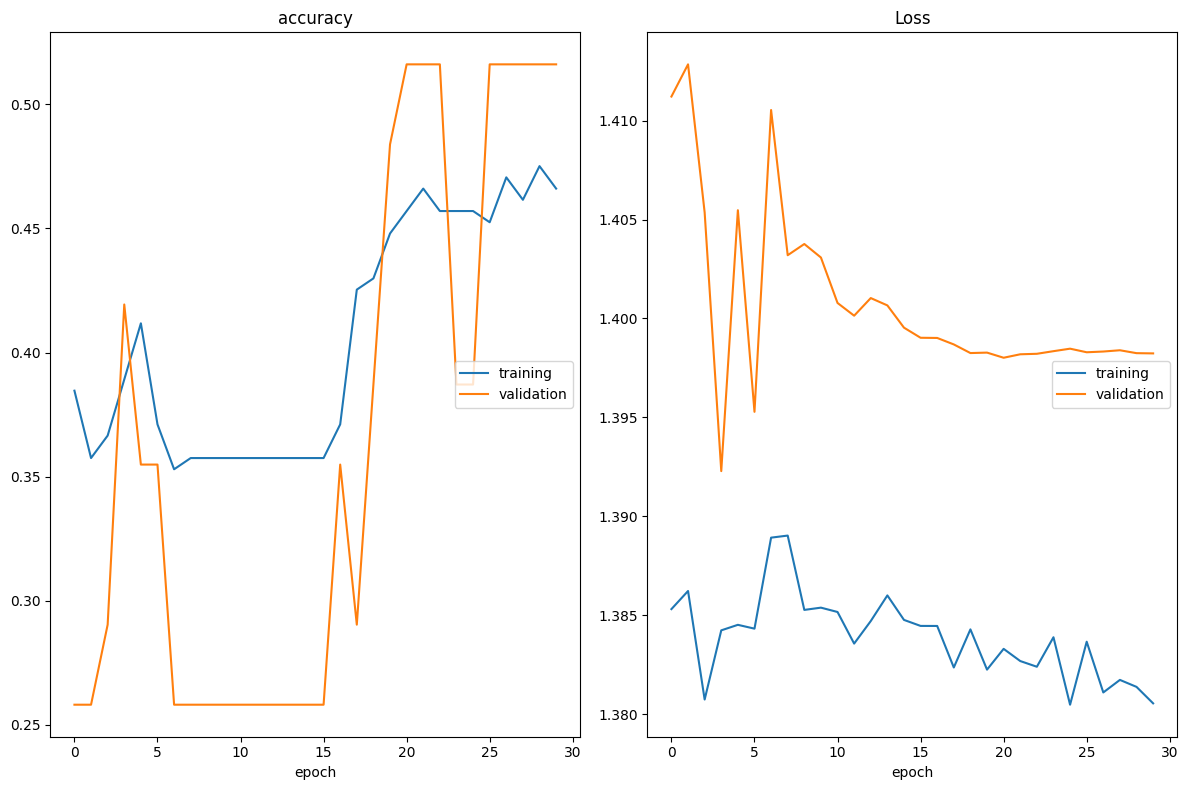

accuracy
	training         	 (min:    0.353, max:    0.475, cur:    0.466)
	validation       	 (min:    0.258, max:    0.516, cur:    0.516)
Loss
	training         	 (min:    1.380, max:    1.389, cur:    1.381)
	validation       	 (min:    1.392, max:    1.413, cur:    1.398)


In [143]:
train_model(
    model=model,
    model_path="grs_01_model.pth",
    train_dl=train_dl,
    val_dl=val_dl,
    criterion=CRITERION,
    optimizer=OPTIMIZER,
    scheduler=SCHEDULER,
    device=device,
    num_epochs=EPOCHS,
)

### 5. Model Evaluation

#### Calculated Metrics
 - F1-Score
 - Accuracy
 - Expected Cost

In [ ]:
# Export Ground Truth
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

subset = test_dl_all.dataset
base_dataset = subset.dataset
indices = subset.indices

all_video_ids = list(base_dataset.videos.keys())
video_ids = [all_video_ids[i] for i in indices]

labels = [int(label) + 1 for _, label in test_dl_all.dataset]  # +1 to convert to [1–4]

df = pd.DataFrame({
    "VIDEO": video_ids,
    "GRS": labels
})

output_path = os.path.join(OUTPUT_FOLDER, "ground_truth.csv")
df.to_csv(output_path, index=False)
print(f"Saved ground truth to {output_path}")

Saved ground truth to ./results/ground_truth.csv


In [16]:
# Predict to .csv
def predict_and_export_csv(model_path: str, dataloader, model_class, model_name:str):
    
    model = model_class().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    subset = dataloader.dataset
    base_dataset = subset.dataset
    indices = subset.indices

    video_names = list(base_dataset.videos.keys())
    video_ids = [video_names[i] for i in indices]

    # Predictons
    preds = []
    with torch.no_grad():
        for inputs, _ in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, dim=1)
            preds.extend(predicted.cpu().numpy())

    preds = [int(p) + 1 for p in preds] # [0-3] -> [1-4]

    df = pd.DataFrame({
        "VIDEO": video_ids,
        "GRS": preds
    })
    
    output_path = os.path.join(OUTPUT_FOLDER, f"{model_name}_results.csv")
    df.to_csv(output_path, index=False)
    print(f"Saved predictions to {output_path}")

In [19]:
predict_and_export_csv(model_path="grs_01_model.pth", dataloader=test_dl_all, model_class=GRSModel_01, model_name="grs_01")

Saved predictions to ./results/grs_01_results.csv


#### It is not possible to run the file provided by the teachers, we will calculate the metrics manually

F1-score (macro / DSC): 0.1682
Expected Cost: 1.0806


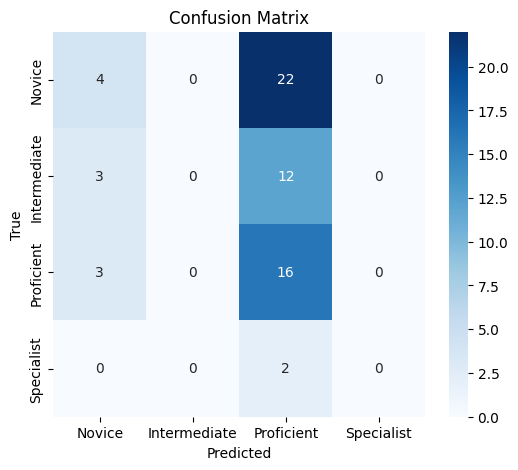

In [20]:
GROUND_TRUTH_PATH = "results/ground_truth.csv"
PREDICTIONS_PATH = "results/grs_01_results.csv"
NUM_CLASSES = 4

df_gt = pd.read_csv(GROUND_TRUTH_PATH)
df_pred = pd.read_csv(PREDICTIONS_PATH)

# Merge
df = pd.merge(df_gt, df_pred, on="VIDEO", suffixes=('_gt', '_pred'))
df = df.rename(columns={"GRS_gt": "ground_truth", "GRS_pred": "prediction"})

# [1-4] -> [0-3]
df[["ground_truth", "prediction"]] = df[["ground_truth", "prediction"]] - 1

# F1 macro
f1 = f1_score(df["ground_truth"], df["prediction"], average='macro')
print(f"F1-score (macro / DSC): {f1:.4f}")

# Expected Cost
cost_matrix = [[abs(i - j) for j in range(NUM_CLASSES)] for i in range(NUM_CLASSES)]
expected_cost = np.mean([
    cost_matrix[gt][pred]
    for gt, pred in zip(df["ground_truth"], df["prediction"])
])
print(f"Expected Cost: {expected_cost:.4f}")

# Confusion Matrix 
cm = confusion_matrix(df["ground_truth"], df["prediction"])
class_names = ["Novice", "Intermediate", "Proficient", "Specialist"]

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()